### **Table of Content**
The notebook has the following key sections:
1. Library imports
2. Data Import and EDA
3. Building various models
4. Summary of models and related MAPEs

I've included some brief commentary throughout the notebook, however most of commentary is included in the readme.md file.

### **Overview:**
The goal of this assignment is to build a prediction model for monthly and daily revenue related to a particular product.

I will import revenue timeseries data, perform EDA, develop and explore several regression models and discuss their advantages and disadvantages, and propose a model or several models that can be used in production for future forecasting.

Benchmark - I will use MAPE as the main way to judge model performance. Its intuitive to understand and its also a measure currently used by the business folks.


### **Data:**
The dataset represents daily revenue for a product at my company. It has two columuns - 'Day' and 'Adj Revenue'. For the purpose of this exercise, we only need monthly data as the forecast ultimately needs to be submitted into the ERP system which only accepts monthly granularity. Also, daily granular data has lots of noise (i.e. revenue on various days is different, from example on weekends), that could negatively impact the forecasting process.

The original revenue data has been modified by multiplying the whole timeseries with one number to obfuscate the original data.



# Imports

In [40]:
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from joblib import parallel_backend

In [42]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, ParameterGrid, train_test_split
from sklearn.utils.multiclass import type_of_target

In [43]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
import scipy as sp

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [45]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import set_config
set_config(display="diagram")

# Data Import and EDA

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# Import the data from Google Drive
# Data represents daily granular revenue for a particular product covering 2015-2019 period
# While the data is daily, ultimately the forecast will be uploaded into the ERP system which accepts
# monthly granularity rather than daily, so will need to resample the data
df = pd.read_csv("drive/MyDrive/Colab Notebooks/Capstone/data_test_2015_2019.csv")

#Lets do some exploration to understand data
df.head()

,Date,Revenue_adj
0,"January 1, 2015","8,921.00"
1,"January 2, 2015","10,080.00"
2,"January 3, 2015","9,717.00"
3,"January 4, 2015","9,591.00"
4,"January 5, 2015","10,297.00"


In [48]:
# Rename column for easy of reference
df.rename(columns={"Revenue_adj": "Revenue"}, inplace=True)

In [49]:
# Set the index to Date, change data type etc so its easier to handle the data
df["Date"] = pd.to_datetime(df["Date"])
df["Revenue"] = df["Revenue"].str.replace(",", "")
df["Revenue"] = df["Revenue"].astype("float32")
df = df.set_index("Date")
print(df.dtypes)


Revenue    float32
dtype: object


<Axes: xlabel='Date'>

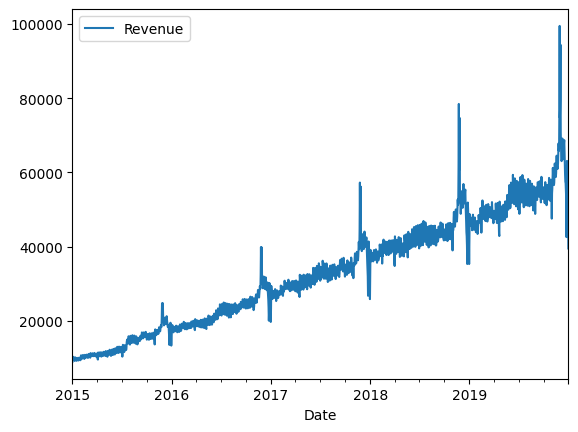

In [50]:
# Now lets vizualize the data
df.plot()
# Data has lots of seasonality and is noisy. It also exihbits very impressive growth

In [51]:
df_original_daily = df.copy()
#df = df_original.copy()

In [52]:
# Daily granularity is not needed for my exercise, therefore will
# change to monthly granularity
df = df.resample('M').sum()
df_original_m = df.copy()

df.head()

,Revenue
Date,
2015-01-31,298520.0
2015-02-28,288460.0
2015-03-31,331214.0
2015-04-30,324255.0
2015-05-31,348226.0


In [53]:
# Lets check again the resampled dataset
print(df.dtypes)
print(df.shape)

Revenue    float32
dtype: object
(60, 1)


In [54]:
# Get some basics stats
print(df.describe())

            Revenue
count  6.000000e+01
mean   9.987264e+05
std    4.523528e+05
min    2.884600e+05
25%    5.817790e+05
50%    9.990140e+05
75%    1.341083e+06
max    1.931336e+06


In [55]:
#Check for repetition (although repetition is not necessarily bad for this time series)
unique_counts = df.nunique()
print(unique_counts)


Revenue    60
dtype: int64


In [56]:
#Check for nulls
print(df.isnull().sum())

Revenue    0
dtype: int64


<Axes: xlabel='Date'>

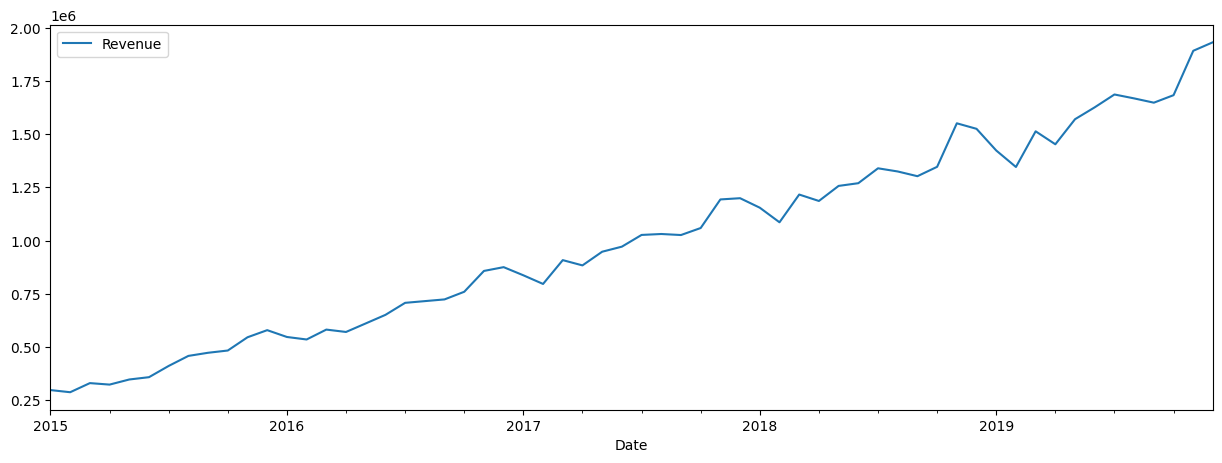

In [57]:
# Plot the revenue over time to examine for trends and seasonality
df.plot(y="Revenue", figsize=(15, 5))
# Again one can observe some sesonality

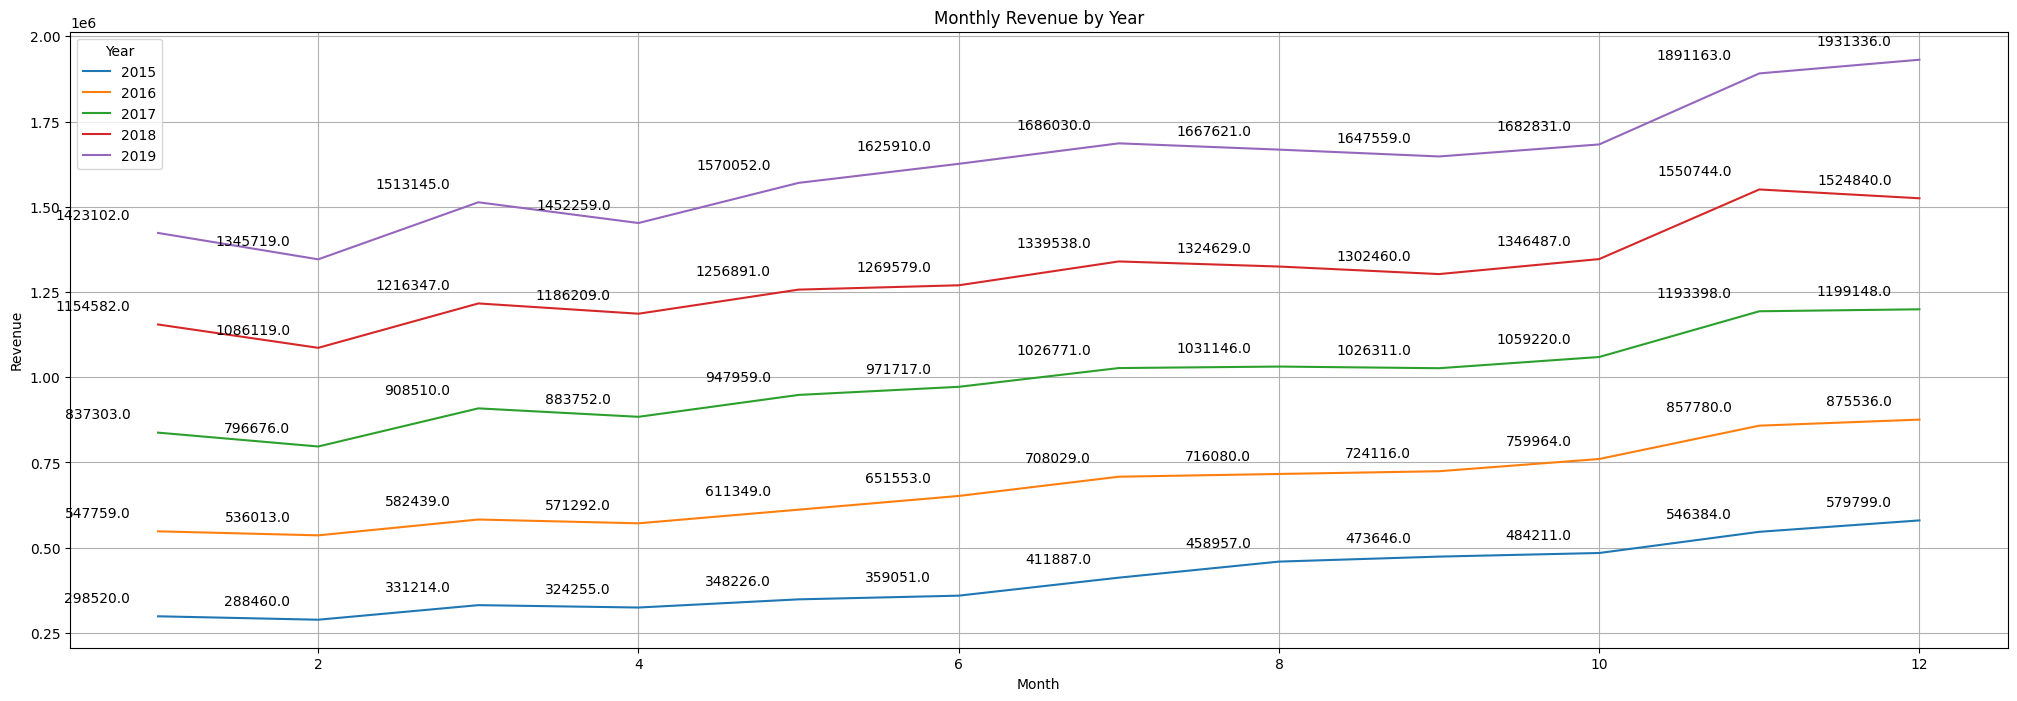

In [58]:
# Create a line chart with lines on top of each to easier observe the annual seasonality

# Create the plot
plt.figure(figsize=(25, 8))

# Plot each year's line
for year, data in df.groupby(df.index.year):
    plt.plot(data.index.month, data['Revenue'], label=year)

    # Add data labels
    for i, (month, revenue) in enumerate(zip(data.index.month, data['Revenue'])):
        plt.annotate(f"{revenue}", xy=(month, revenue), xytext=(-20, 10), textcoords="offset points", ha="right")

plt.title('Monthly Revenue by Year')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend(title='Year')
plt.grid(True)
plt.show()
# This shows a much more pronounced annual seasonality, for example a spike in month 3,
# followed by a drop in month 4 and further spike in month 11 (likely due to Black Friday and CyberMonday sales)

<Axes: >

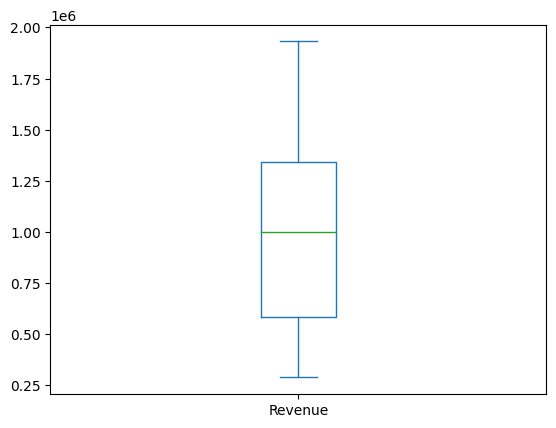

In [59]:
# Lets check for any outliers in the revenue
df["Revenue"].plot(kind="box")

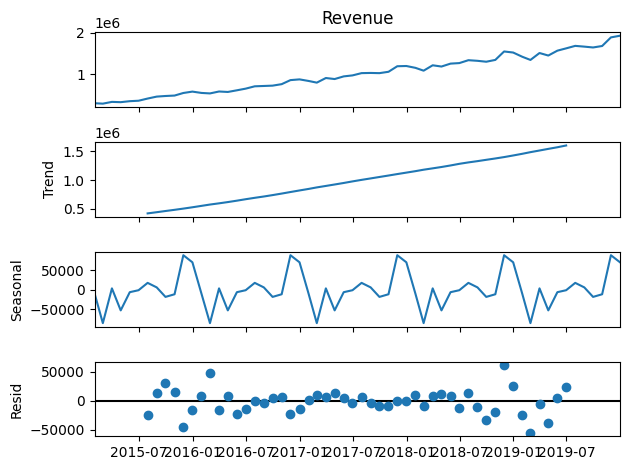

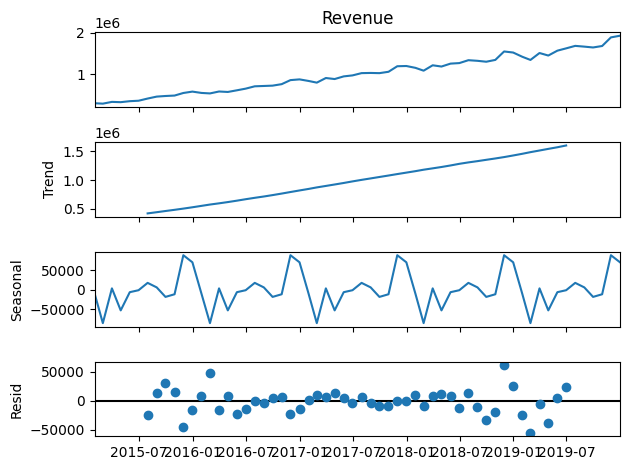

In [60]:
# Lets explore the seasonality and decompose the revenue
from statsmodels.tsa.seasonal import seasonal_decompose

# Call the seasonal_decompose function on the timeseries
result = seasonal_decompose(df["Revenue"], model='additive')

# Plot the results of the seasonal_decompose function
result.plot()

# Looks like there is meaningful almost linear growth as showed by Trend line, and very pronounced seasonality

<Axes: xlabel='Date'>

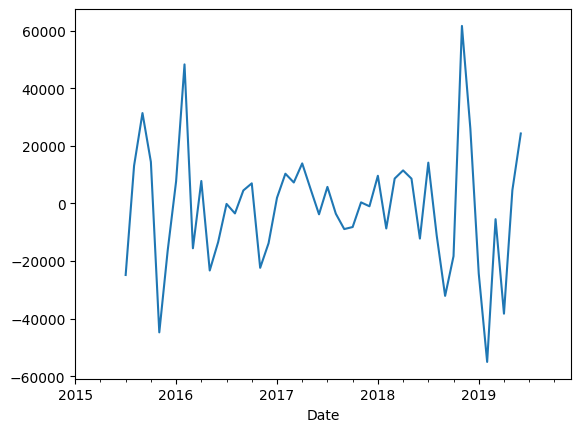

In [61]:
# Lets look at the residual component only to see if there is any material trends left.
df["Revenue_resid"] = result.resid

# Plot the residual:
df["Revenue_resid"].plot()

# This is relatively immaterial and looks more like noise as does not exhibit any meaningful trends

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

# CREATE A DATAFRAME TO COLLECT MAPEs for various models

In [62]:
# Create an empty DataFrame
mape_df = []
mape_df = pd.DataFrame(columns=['Model', 'Train MAPE', 'Test MAPE'])

#create a function to append MAPEs to dataframe
def append_mape_to_df(model_name, train_mape, test_mape):
    global mape_df
    mape_df = mape_df.append({
        'Model': model_name,
        'Train MAPE': train_mape,
        'Test MAPE': test_mape
    }, ignore_index=True)

# BUILDING A SARIMAX MONTHLY MODEL

MAPE: 0.0362573655448537


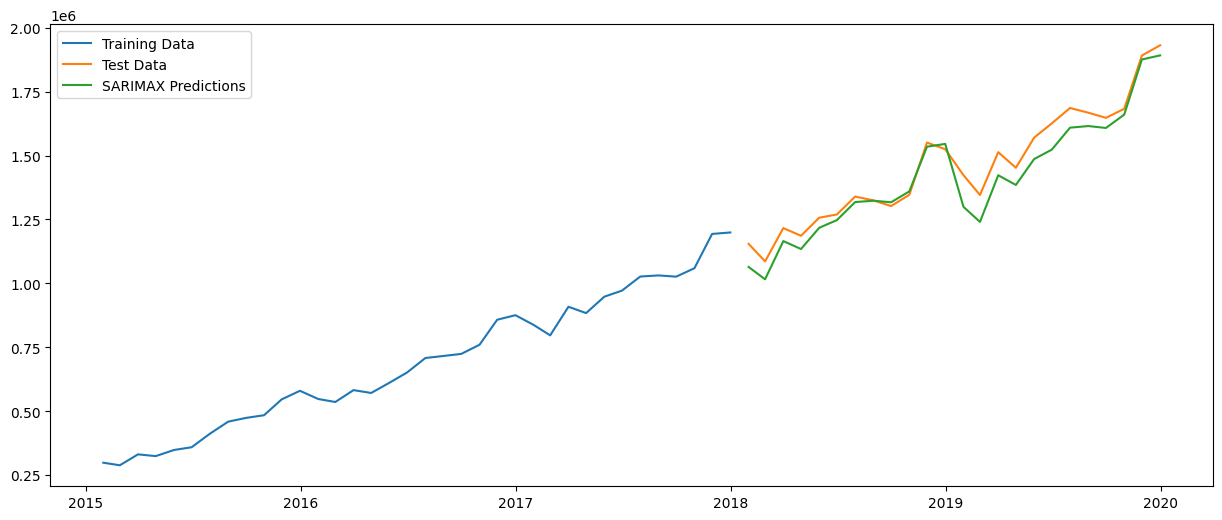

In [63]:
# LETS BUILD A SARIMAX MODEL WHICH IS BEST SUITED FOR THIS TYPE OF MODELLING
df = df_original_m.copy()
# Split the DataFrame into a development set and a test set
train = df.loc["2015-01-01":"2017-12-31"]
test = df.loc["2018-01-01":"2019-12-31"]

# Fit the SARIMA model on the training set
model = SARIMAX(train["Revenue"], order=(3, 0, 0), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()


# Forecast the values for the test set
predictions = model_fit.predict(start=test.index[0], end=test.index[-1])

mape_train = 0 #not calculated
mape_test = MAPE(test["Revenue"], predictions)

append_mape_to_df('SARIMAX Monthly', mape_train, mape_test)

# Print the RMSE and % error
print("MAPE:", mape_test)

# Plot the original data and the predictions
plt.figure(figsize=(15, 6))
plt.plot(train["Revenue"], label="Training Data")
plt.plot(test["Revenue"], label="Test Data")
plt.plot(predictions, label="SARIMAX Predictions")
plt.legend()
plt.savefig("drive/MyDrive/Colab Notebooks/Capstone/images/sarimax.png")
plt.show()

# BIULDING A SARIMAX MODEL WITH DAILY GRANULARITY

In [64]:
# df = df_original_daily.copy()  # Assuming df_original_d is your daily granularity dataframe

# # Split the DataFrame into a development (training) set and a test set
# train = df.loc["2015-01-01":"2017-12-31"]
# test = df.loc["2018-01-01":"2019-12-31"]

# # Fit the SARIMAX model on the training set
# # Using daily seasonality: seasonal_order's 's' is set to 365 to represent a year in days
# model = SARIMAX(train["Revenue"], order=(3, 0, 0), seasonal_order=(1, 1, 1, 365))
# model_fit = model.fit(disp=False)  # Set disp to False to prevent convergence messages from being printed

# # Forecast the values for the test set
# predictions = model_fit.predict(start=test.index[0], end=test.index[-1])

# mape_train = 0  # Not calculated
# mape_test = MAPE(test["Revenue"], predictions)

# append_mape_to_df('SARIMAX Daily', mape_train, mape_test)

# # Print the MAPE
# print("MAPE:", mape_test)

# # Plot the original data and the predictions
# plt.figure(figsize=(15, 6))
# plt.plot(train["Revenue"], label="Training Data")
# plt.plot(test["Revenue"], label="Test Data")
# plt.plot(predictions, label="SARIMAX Predictions")
# plt.legend()
# plt.savefig("drive/MyDrive/Colab Notebooks/Capstone/images/sarimax_daily.png")
# plt.show()


# BUILDING A PROPHET MONTHLY MODEL


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp90a1w5bv/n8mha9ia.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp90a1w5bv/al7qop4t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55780', 'data', 'file=/tmp/tmp90a1w5bv/n8mha9ia.json', 'init=/tmp/tmp90a1w5bv/al7qop4t.json', 'output', 'file=/tmp/tmp90a1w5bv/prophet_model0hpzr5c3/prophet_model-20230926052325.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:23:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:23:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Train MAPE: 0.011629724543169684
Test MAPE: 0.02957812606754044


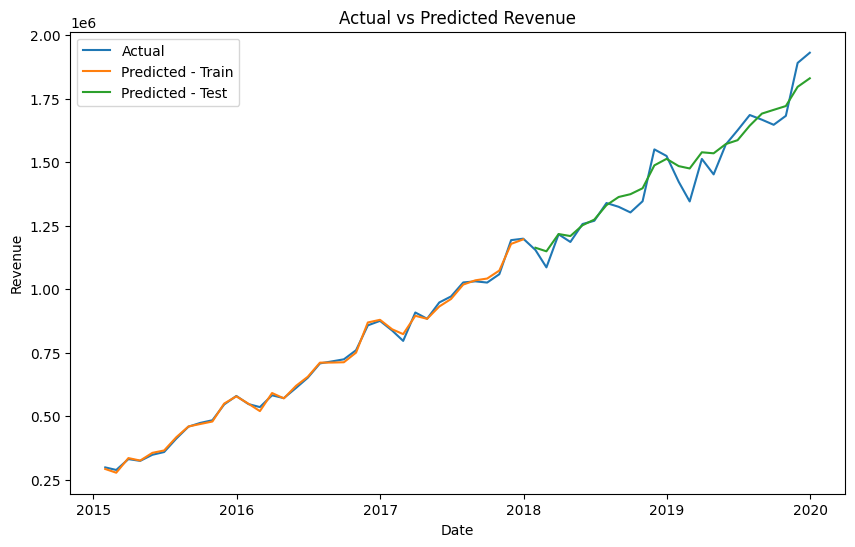

In [65]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

df = df_original_m.copy()
df = df.reset_index()

df.rename(columns={'Date': 'ds', 'Revenue': 'y'}, inplace=True)

# Split the data into train and test datasets
train = df[df['ds'] < '2018-01-01']
test = df[df['ds'] >= '2018-01-01']

# Initialize Prophet and fit the model
model = Prophet(yearly_seasonality=True)
model.fit(train)

# Make predictions
forecast_train = model.predict(train[['ds']])
forecast_test = model.predict(test[['ds']])

# Calculate MAPE for train and test datasets
mape_train = MAPE(train['y'], forecast_train['yhat'])
mape_test = MAPE(test['y'], forecast_test['yhat'])

append_mape_to_df('PROPHET Monthly', mape_train, mape_test)

print(f'Train MAPE: {mape_train}')
print(f'Test MAPE: {mape_test}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df['ds'], df['y'], label='Actual')
plt.plot(train['ds'], forecast_train['yhat'], label='Predicted - Train')
plt.plot(test['ds'], forecast_test['yhat'], label='Predicted - Test')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue')
plt.savefig("drive/MyDrive/Colab Notebooks/Capstone/images/prophet_monthly.png")
plt.show()


# BUILDING A PROPHET DAILY MODEL

DEBUG:cmdstanpy:input tempfile: /tmp/tmp90a1w5bv/o4quxf3o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp90a1w5bv/8utqaozg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99839', 'data', 'file=/tmp/tmp90a1w5bv/o4quxf3o.json', 'init=/tmp/tmp90a1w5bv/8utqaozg.json', 'output', 'file=/tmp/tmp90a1w5bv/prophet_modelwybaszib/prophet_model-20230926052326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:23:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:23:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Train MAPE: 0.03419110644900607
Test MAPE: 0.03449386483290055


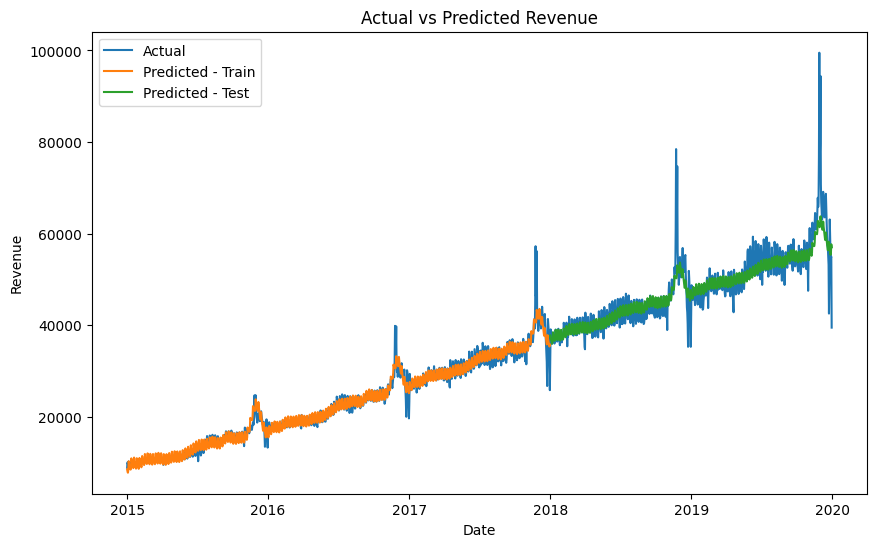

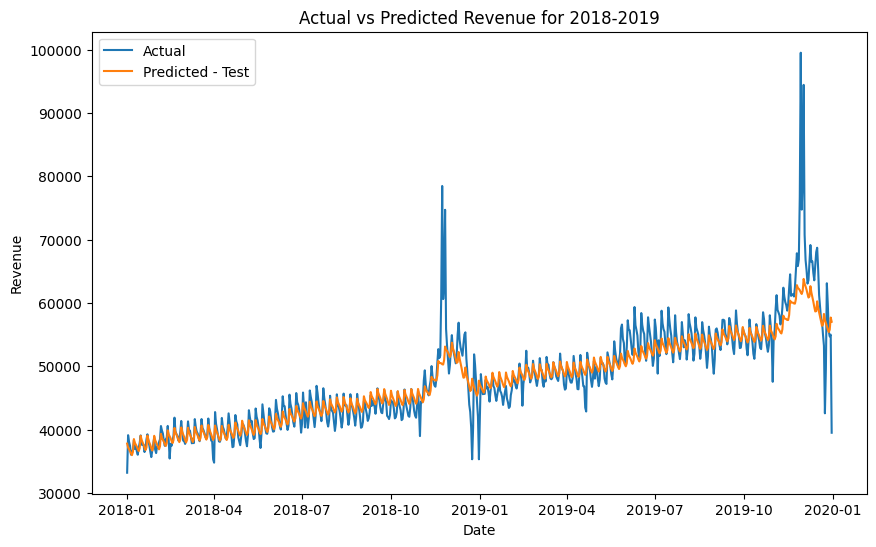

In [66]:
from prophet import Prophet

df = df_original_daily.copy()
df = df.reset_index()

df.rename(columns={'Date': 'ds', 'Revenue': 'y'}, inplace=True)

# Split the data into train and test datasets
train = df[df['ds'] < '2018-01-01']
test = df[df['ds'] >= '2018-01-01']

# Initialize Prophet and fit the model
model = Prophet(yearly_seasonality=True, daily_seasonality=True, weekly_seasonality=True)
model.fit(train)

# Make predictions
forecast_train = model.predict(train[['ds']])
forecast_test = model.predict(test[['ds']])

# Calculate MAPE for train and test datasets
mape_train = MAPE(train['y'], forecast_train['yhat'])
mape_test = MAPE(test['y'], forecast_test['yhat'])

append_mape_to_df('PROPHET Daily', mape_train, mape_test)

print(f'Train MAPE: {mape_train}')
print(f'Test MAPE: {mape_test}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df['ds'], df['y'], label='Actual')
plt.plot(train['ds'], forecast_train['yhat'], label='Predicted - Train')
plt.plot(test['ds'], forecast_test['yhat'], label='Predicted - Test')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue')

# Filter data for the years 2018-2019
test_2018_2019 = test[(test['ds'] >= '2018-01-01') & (test['ds'] <= '2019-12-31')]
forecast_test_2018_2019 = forecast_test[(forecast_test['ds'] >= '2018-01-01') & (forecast_test['ds'] <= '2019-12-31')]

# Plot the results for 2018-2019
plt.figure(figsize=(10, 6))
plt.plot(test_2018_2019['ds'], test_2018_2019['y'], label='Actual')
plt.plot(forecast_test_2018_2019['ds'], forecast_test_2018_2019['yhat'], label='Predicted - Test')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue for 2018-2019')
plt.savefig("drive/MyDrive/Colab Notebooks/Capstone/images/prophet_daily.png")
plt.show()


# BUILDING A MONTHLY LSTM MODEL

1/1 [==============================] - 1s 522ms/step
Train MAPE: 0.029658346811611967
Test MAPE: 0.08646984933984336


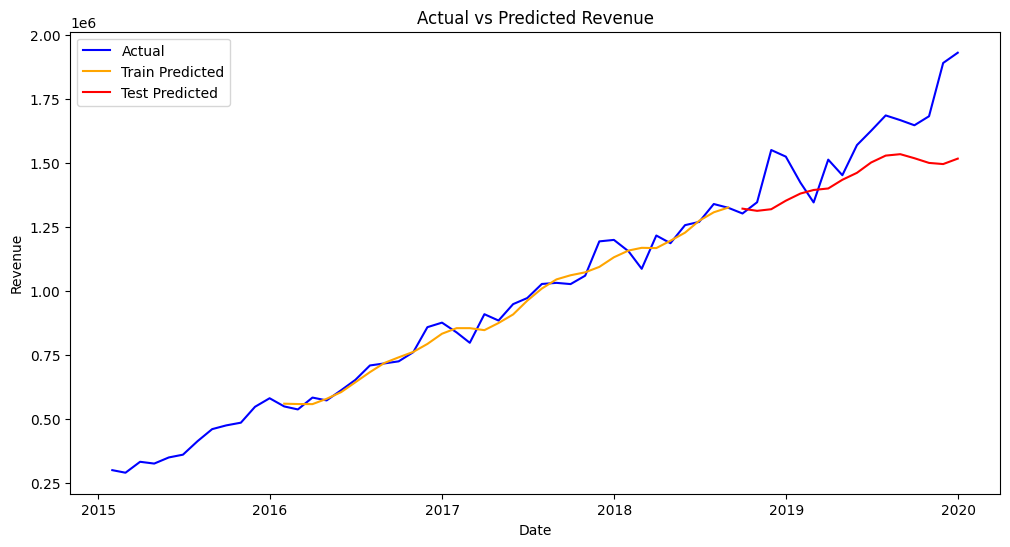

In [67]:
df = df_original_m.copy()


# Feature Engineering: Adding sine and cosine transformations of the month index
df['month_sin'] = np.sin(2 * np.pi * (df.index.month - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df.index.month - 1) / 12)

# Normalizing the Data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Prepare Data for LSTM
look_back = 12  # Number of previous time steps to use as input variables to predict the next time period
X, Y = [], []
for i in range(len(df_scaled) - look_back):
    X.append(df_scaled[i:(i + look_back), :])
    Y.append(df_scaled[i + look_back, 0])  # 0 is the index of the 'Revenue' column in df_scaled

X = np.array(X)
Y = np.array(Y)

# Splitting Data into Train and Test Sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size, :], X[train_size:len(X), :]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# Building and Training the LSTM Model
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, df_scaled.shape[1])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=0)

# Making Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverting Predictions to Original Scale for Interpretation
train_predict = scaler.inverse_transform(np.hstack((train_predict, X_train[:, -1, 1:])))[:, 0]
Y_train = scaler.inverse_transform(np.hstack((Y_train.reshape(-1, 1), X_train[:, -1, 1:])))[:, 0]
test_predict = scaler.inverse_transform(np.hstack((test_predict, X_test[:, -1, 1:])))[:, 0]
Y_test = scaler.inverse_transform(np.hstack((Y_test.reshape(-1, 1), X_test[:, -1, 1:])))[:, 0]

mape_train = MAPE(Y_train, train_predict)
mape_test = MAPE(Y_test, test_predict)

append_mape_to_df('LSTM Monthly', mape_train, mape_test)

print(f'Train MAPE: {mape_train}')
print(f'Test MAPE: {mape_test}')

# Plotting Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Revenue'], label='Actual', color='blue')
plt.plot(df.index[look_back:train_size + look_back], train_predict, label='Train Predicted', color='orange')
plt.plot(df.index[train_size + look_back:], test_predict, label='Test Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue')
plt.legend(loc='upper left')
plt.savefig("drive/MyDrive/Colab Notebooks/Capstone/images/LSTM_monthly.png")
plt.show()

# BUILDING A DAILY LSTM MODEL

Epoch 1/10
1095/1095 [==============================] - 10s 6ms/step - loss: 0.0115
Epoch 2/10
1095/1095 [==============================] - 6s 6ms/step - loss: 8.7526e-04
Epoch 3/10
1095/1095 [==============================] - 4s 4ms/step - loss: 9.1149e-04
Epoch 4/10
1095/1095 [==============================] - 6s 6ms/step - loss: 8.4162e-04
Epoch 5/10
1095/1095 [==============================] - 7s 6ms/step - loss: 9.1756e-04
Epoch 6/10
1095/1095 [==============================] - 4s 4ms/step - loss: 8.5020e-04
Epoch 7/10
1095/1095 [==============================] - 6s 6ms/step - loss: 8.0716e-04
Epoch 8/10
1095/1095 [==============================] - 4s 4ms/step - loss: 8.0504e-04
Epoch 9/10
1095/1095 [==============================] - 4s 3ms/step - loss: 7.6368e-04
Epoch 10/10
23/23 [==============================] - 0s 3ms/step
Train MAPE: 0.04378839209675789
Test MAPE: 0.029377011582255363


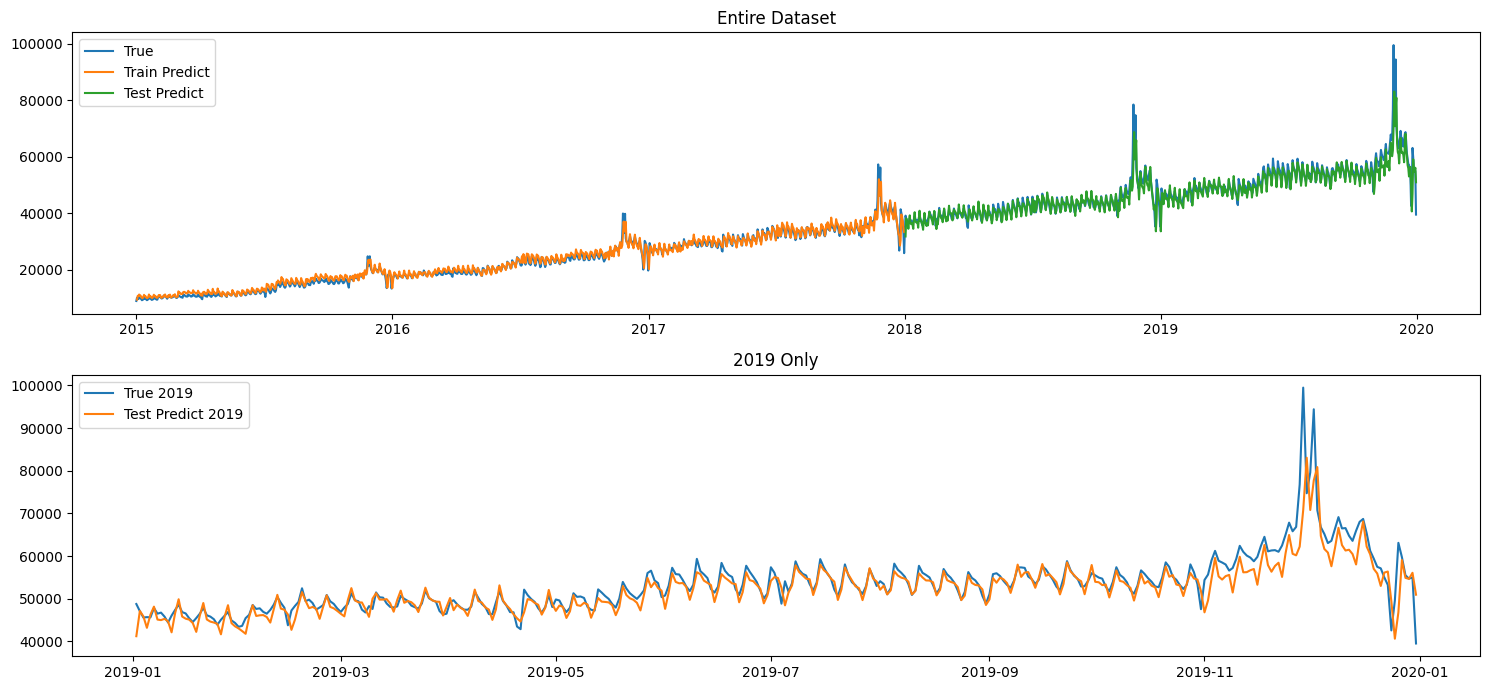

In [68]:
df = df_original_daily.copy()

# Extract train and test sets
train = df['2015-01-01':'2017-12-31']
test = df['2018-01-01':'2019-12-31']

# Feature Engineering: Create formula to add day of week and month as one-hot encoded features
def add_features(df):
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df = pd.get_dummies(df, columns=['day_of_week', 'month'], prefix=['dow', 'm'], drop_first=True)
    return df

# Implementing adding features
train = add_features(train)
test = add_features(test)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Prepare the data
def create_dataset(dataset, target_index, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, target_index])
    return np.array(X), np.array(Y)

look_back = 1  # I've experimented with several values here (tried 7, 14), and 1 resulted in lowest MAPE
target_index = 0 # For Revenue in my dataset
X_train, y_train = create_dataset(train_scaled, target_index, look_back)
X_test, y_test = create_dataset(test_scaled, target_index, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Create LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Function to inverse transform the predictions
def inverse_transform_predictions(train_predict, test_predict, scaler, train, test):
    train_predict = scaler.inverse_transform(np.hstack((train_predict, train.iloc[look_back:, 1:].values)))[:, 0]
    test_predict = scaler.inverse_transform(np.hstack((test_predict, test.iloc[look_back:, 1:].values)))[:, 0]
    return train_predict, test_predict

# Inverse transform the predictions to get them on the original scale
train_predict, test_predict = inverse_transform_predictions(train_predict, test_predict, scaler, train, test)

# Extract the corresponding actual values from the original DataFrame
y_train_actual = df.loc['2015-01-01':'2017-12-31', 'Revenue'].values
y_test_actual = df.loc['2018-01-01':'2019-12-31', 'Revenue'].values

# Trim the first 'look_back' elements as they don’t have corresponding predictions
y_train_actual = y_train_actual[look_back:]
y_test_actual = y_test_actual[look_back:]

# Calculate MAPE for train and test data
mape_train = MAPE(y_train_actual, train_predict)
mape_test = MAPE(y_test_actual, test_predict)

append_mape_to_df('LSTM Daily', mape_train, mape_test)

print(f'Train MAPE: {mape_train}')
print(f'Test MAPE: {mape_test}')

# Plot the results
plt.figure(figsize=(15,7))

# Plot for the entire dataset
plt.subplot(2, 1, 1)
plt.title('Entire Dataset')
plt.plot(df.index, df['Revenue'], label='True')
plt.plot(train.index[look_back:], train_predict, label='Train Predict')
plt.plot(test.index[look_back:], test_predict, label='Test Predict')
plt.legend()

# Plot for only 2019
plt.subplot(2, 1, 2)
plt.title('2019 Only')
df_2019 = df['2019-01-01':'2019-12-31']
start_index_2019 = df_2019.index[look_back]
plt.plot(df_2019.loc[start_index_2019:]['Revenue'], label='True 2019')
plt.plot(df_2019.loc[start_index_2019:].index, test_predict[-len(df_2019.loc[start_index_2019:]):], label='Test Predict 2019')
plt.legend()

plt.tight_layout()
plt.savefig("drive/MyDrive/Colab Notebooks/Capstone/images/LSTM_daily.png")
plt.show()


# BUILDING A RANDOM FOREST MODEL WITH TRAIN/TEST (poor results)

Train MAPE: 0.014429112525282037
Test MAPE: 0.22043744516094232


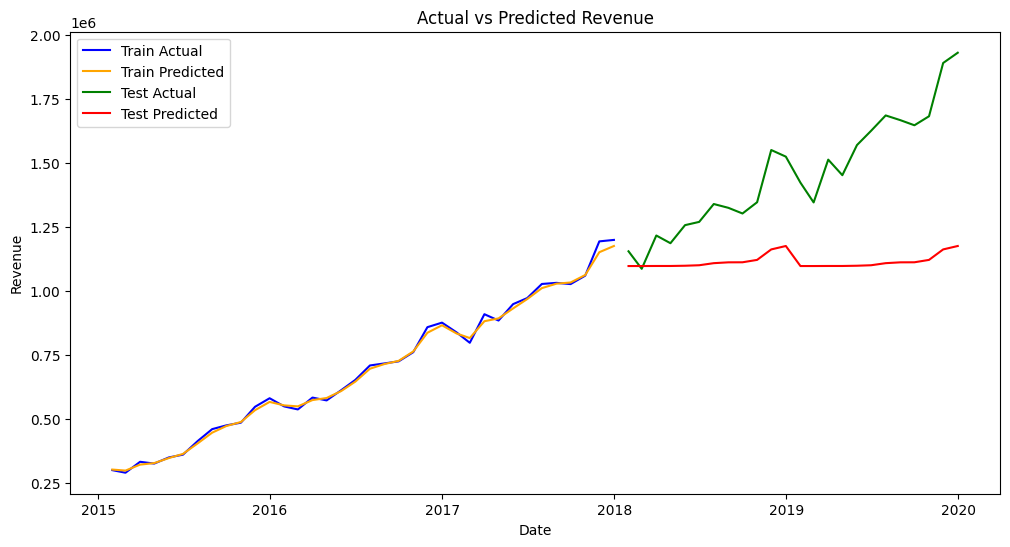

In [69]:
df = df_original_m.copy()

# Feature Engineering
df['Year'] = df.index.year
df['Month'] = df.index.month

# Additional Feature Engineering
# Creating lagged features
# lags = 12  # for 12 months
# for i in range(1, lags + 1):
#     df[f'lag_{i}'] = df['Revenue'].shift(i)

# Creating rolling window features
# window_size = 12  # you can change this
# df['rolling_mean'] = df['Revenue'].shift().rolling(window=window_size).mean()
# df['rolling_std'] = df['Revenue'].shift().rolling(window=window_size).std()

# Creating a linear trend feature
df['trend'] = range(len(df))

# Drop NaN values created due to lag and rolling window features
# df = df.dropna()

# Split Data into Train and Test
train = df['2015-01-01':'2017-12-31']
test = df['2018-01-01':'2019-12-31']

# Train Random Forest Model
X_train = train.drop('Revenue', axis=1)
y_train = train['Revenue']
X_test = test.drop('Revenue', axis=1)
y_test = test['Revenue']

model = RandomForestRegressor(n_estimators=200)
model.fit(X_train, y_train)

# Make Predictions
train['Predicted'] = model.predict(X_train)
test['Predicted'] = model.predict(X_test)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_train = MAPE(train['Revenue'], train['Predicted'])
mape_test = MAPE(test['Revenue'], test['Predicted'])

append_mape_to_df('RandomForest Monthly', mape_train, mape_test)

print(f'Train MAPE: {mape_train}')
print(f'Test MAPE: {mape_test}')

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Revenue'], label='Train Actual', color='blue')
plt.plot(train.index, train['Predicted'], label='Train Predicted', color='orange')
plt.plot(test.index, test['Revenue'], label='Test Actual', color='green')
plt.plot(test.index, test['Predicted'], label='Test Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Predicted Revenue')
plt.legend(loc='upper left')
plt.savefig("drive/MyDrive/Colab Notebooks/Capstone/images/RandForest_monthly.png")
plt.show()


# BUILDING A XGBOOST MODEL WITH TRAIN/TEST (poor results)

Train MAPE: 0.00%
Test MAPE: 0.19%


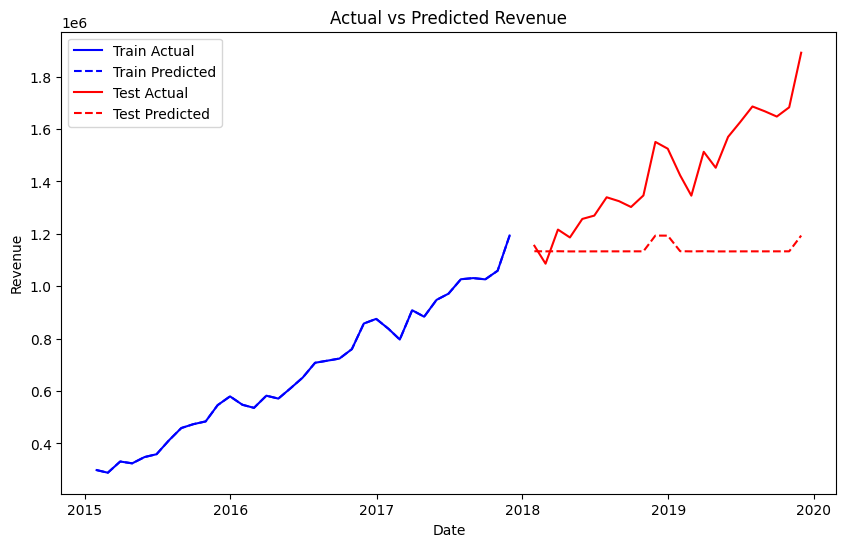

In [70]:
# BUILDING A XGBOOST MODEL
import xgboost as xgb

df = df_original_m.copy()

# Splitting Train/Test data
train_df = df.loc['2015-01-01':'2017-12-01']
test_df = df.loc['2018-01-01':'2019-12-01']

# Feature Engineering
train_df['Month'] = train_df.index.month
train_df['Year'] = train_df.index.year
train_df['Time'] = range(len(train_df))
train_df['Month_Year_Interaction'] = train_df['Month'] * train_df['Year']

test_df['Month'] = test_df.index.month
test_df['Year'] = test_df.index.year
test_df['Time'] = range(len(train_df), len(train_df) + len(test_df))
test_df['Month_Year_Interaction'] = test_df['Month'] * test_df['Year']

# XGBoost Model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)

# Training Model
features = ['Month', 'Year', 'Time', 'Month_Year_Interaction']
model.fit(train_df[features], train_df['Revenue'])

# Predicting Train and Test
train_df['Prediction'] = model.predict(train_df[features])
test_df['Prediction'] = model.predict(test_df[features])

# Calculating MAPE for Train and Test Data
mape_train = MAPE(train_df['Revenue'], train_df['Prediction'])
mape_test = MAPE(test_df['Revenue'], test_df['Prediction'])

append_mape_to_df('XG Boost Monthly', mape_train, mape_test)

print(f'Train MAPE: {mape_train:.2f}%')
print(f'Test MAPE: {mape_test:.2f}%')

# Plotting Actual vs Predicted
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Revenue'], label='Train Actual', color='blue')
plt.plot(train_df.index, train_df['Prediction'], label='Train Predicted', color='blue', linestyle='dashed')
plt.plot(test_df.index, test_df['Revenue'], label='Test Actual', color='red')
plt.plot(test_df.index, test_df['Prediction'], label='Test Predicted', color='red', linestyle='dashed')
plt.legend()
plt.title('Actual vs Predicted Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.savefig("drive/MyDrive/Colab Notebooks/Capstone/images/XGBoost_monthly.png")
plt.show()


# SUMMARY

In [71]:
#Lets look at the collected MAPEs
mape_df

,Model,Train MAPE,Test MAPE
0,SARIMAX Monthly,0,0.036257
1,PROPHET Monthly,0.01163,0.029578
2,PROPHET Daily,0.034191,0.034494
3,LSTM Monthly,0.029658,0.086470
4,LSTM Daily,0.043788,0.029377
5,RandomForest Monthly,0.014429,0.220437
6,XG Boost Monthly,0.0,0.194975


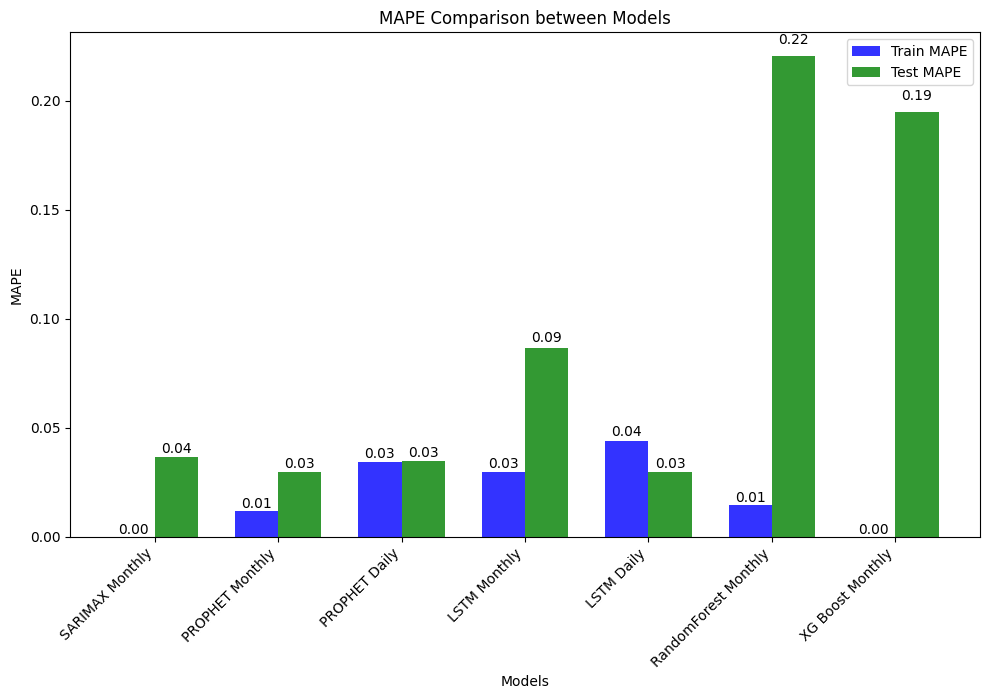

In [72]:
#Lets draw a bar chart showing the MAPE performance of each model

plt.figure(figsize=(10, 6))

n_models = len(mape_df)
bar_width = 0.35
opacity = 0.8
labels = mape_df['Model'].tolist()
index = np.arange(n_models)

# Function to auto-label bars
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 1.02 * height,
                '{:.2f}'.format(height), ha='center', va='bottom')

ax = plt.gca()

rects1 = ax.bar(index, mape_df['Train MAPE'], bar_width, alpha=opacity, color='b', label='Train MAPE')
rects2 = ax.bar(index + bar_width, mape_df['Test MAPE'], bar_width, alpha=opacity, color='g', label='Test MAPE')

autolabel(rects1, ax)  # Add data labels for Train MAPE bars
autolabel(rects2, ax)  # Add data labels for Test MAPE bars

plt.xlabel('Models')
plt.ylabel('MAPE')
plt.title('MAPE Comparison between Models')
plt.xticks(index + bar_width / 2, labels)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.savefig("drive/MyDrive/Colab Notebooks/Capstone/images/Summary.png")
plt.show()


The following models performed really well on the test data, well within acceptable precision expected by business folks: Sarimax (monthly), Prophet (both monthly and daily), and LSTM daily.

I have not been able to run SARIMAX daily as it was timing out and running out of resources.

I could have spend more time optimizing the other models in an effort to improve their accuracy, however the models above have provided sufficient accuracy and can be recommended based on this analysis.